In [1]:
import os
import spacy
import string
import tqdm
import csv
from gensim.models import Word2Vec
import gensim
from collections import defaultdict
import math
import pandas as pd
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
import tempfile
import seaborn as sns
from scipy.spatial.distance import cosine
from wordfreq import top_n_list
from wordcloud import WordCloud
from functions import preprocess_text
from functions import tfidf
from functions import get_decade
from functions import random_tfidf
from functions import words_intervals
from functions import get_mapping
from functions import similar_words_df
from functions import semantic_drift_time
from functions import get_interval
from functions import make_intervals
from functions import projected_vector
from functions import extract_years
from functions import get_period_from_model

In [2]:
nlp = spacy.load("es_core_news_sm")
nlp.max_length = 2000000

We make a loop, where we input every law into the preprocessing function, and we store the results in a list

In [ ]:
files = os.listdir('./input/')[1:]
data = []
for file in tqdm.tqdm(files):
    filepath = './input/' + file
    match = re.search(r'Ley (\d+)_texto_(\d+)', file)
    if match:
        ley_numero = match.group(1)  
        año = match.group(2)

        with open(filepath, 'r', encoding='utf-8') as text_file:
            file_content = text_file.read()
            clean_content = preprocess_text(file_content, True, False)

        data.append((ley_numero, año, clean_content))
        
with open('./input/clean_data.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)
    
del file, file_content, filepath, files, ley_numero, match, nlp, text_file, año, clean_content

To avoid cleaning the data every time, we store it

In [2]:
csv.field_size_limit(10_000_000)
clean_data = []
with open('./input/clean_data.csv', 'r', encoding='utf-8', newline='') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        row[2] = ast.literal_eval(row[2])
        clean_data.append(row)

del reader, row, csv_file

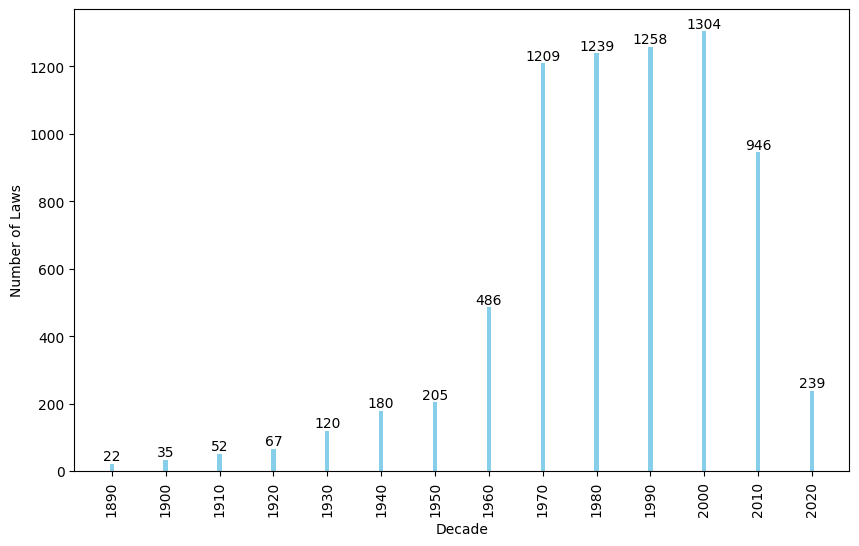

In [3]:
decades, counts = np.unique([get_decade(int(year)) for _, year, _ in clean_data], return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(decades, counts, width=0.8, color='skyblue') 
plt.xticks(decades, rotation=90)

for i, count in enumerate(counts):
    plt.text(decades[i], count+0.5, str(count), ha='center', va='bottom')

plt.xlabel('Decade')
plt.ylabel('Number of Laws')

plt.savefig('./output/laws_for_decade.png')

plt.show()

del decades, counts, i, count

As we can see, the amount of laws per decade are very unbalanced, this is probably due to the fact that the earlier on they were written, the less likely it is that they have been digitalized. We will have to make some decisions on how to balance these numbers for the analysis.

In [5]:
bootstrap = random_tfidf(clean_data, 111, 1000)
bootstrap = bootstrap.fillna(0)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [13:10<00:00,  1.26it/s]


In [6]:
mean_boot = bootstrap.mean(axis = 1)
sd_boot = bootstrap.std(axis = 1)
t_stat = mean_boot*(len(bootstrap.columns)**(1/2))/sd_boot

In [7]:
important_words = t_stat.loc[t_stat > 6.3]

## Word2Vec

In [8]:
intervals = make_intervals()
laws_by_decade = defaultdict(list)
for law, year, words in clean_data:
	year = int(year)
	for interval in intervals:
		if year in interval:
			laws_by_decade[f'{interval[0]}-{interval[-1]}'].append((law, year, words))
selected_laws = []
random.seed(111)
for decade, laws in laws_by_decade.items():
    selected_laws.extend(random.sample(laws, 50))

del law, year, words, interval, laws, decade, laws_by_decade

We now compute the Word2Vec models across each interval, so first, we transform our data in order for it to be compatible with the Word2Vec function, creating a list that encompasses all the words for every law within each interval

In [9]:
words_by_interval = words_intervals(selected_laws)

We compute every Word2Vec model

In [10]:
for interval, words in tqdm.tqdm(words_by_interval.items()):
    globals()[f"model_{interval}"] = Word2Vec(words, vector_size= 300, window= 5, workers= 5) 

del interval, words

100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


In [11]:
for interval, _ in tqdm.tqdm(words_by_interval.items()):
    model = globals()[f'model_{interval}']
    with tempfile.NamedTemporaryFile(prefix= f'gensim-model-{interval}', delete=False) as tmp:
        model.save(f'./word2vec_models/gensim-model-{interval}')

del interval, model, tmp

100%|██████████| 13/13 [00:00<00:00, 106.91it/s]


## Analysis

We load the Word2Vec models prevously stored

In [12]:
intervals = make_intervals()
for interval in intervals:
    start = interval[0]
    end = interval[-1]
    model_file = os.path.join('./word2vec_models/', f'gensim-model-{start}_{end}')
    try:
        os.path.exists(model_file)
        globals()[f'model_{start}_{end}'] = gensim.models.Word2Vec.load(model_file)
    except Exception as e:
        print(e)
        
del interval, start, end, model_file

## Most similar Words

We identify in which models whould we look for these most recurrent words, since they are not likely to be in every model

In [13]:
models_to_use = defaultdict(set)
for word in important_words.index:
    for interval in intervals:
        model = globals()[f'model_{interval[0]}_{interval[-1]}']
        if word in model.wv:
                models_to_use[word].add(f'model_{interval[0]}_{interval[-1]}')
                
models_to_use = {word: list(models) for word, models in models_to_use.items()}

In [20]:
def bootstrap_word2vec(word, data, seed, bootstrap_iterations = 100):
    intervals = make_intervals()
    laws_by_decade = defaultdict(list)
    for law, year, words in data:
        year = int(year)
        for interval in intervals:
            if year in interval:
                laws_by_decade[f'{interval[0]}-{interval[-1]}'].append((law, year, words))
    
    bootstrap_results = defaultdict(pd.DataFrame)
    for iter in tqdm.tqdm(range(bootstrap_iterations)):
        selected_laws = []
        random.seed(seed + iter)
        for decade, laws in laws_by_decade.items():
            selected_laws.extend(random.sample(laws, 50))
        
        words_by_interval = words_intervals(selected_laws)
        for interval, words in words_by_interval.items():
            globals()[f"model_{interval}"] = Word2Vec(words, vector_size= 300, window= 5, workers= 5) 
            
        similarities = pd.DataFrame()    
        for interval in intervals:
            model = globals()[f'model_{interval[0]}_{interval[-1]}']
            if word in model.wv:
                similar_words = pd.DataFrame(model.wv.most_similar(word, topn = 100), columns= ['word', f'{interval[0]}-{interval[-1]}'])
                similar_words = similar_words.set_index('word')
                similarities = pd.concat([similarities, similar_words])
        bootstrap_results[iter] = similarities
        
        common_words = list(set.intersection(*[set(df.index) for df in bootstrap_results.values()]))

        filtered_similarities = [similarities.loc[common_words].groupby(level = 0).mean() for similarities in bootstrap_results.values()]
        
        results = pd.DataFrame()
        for iter in bootstrap_results:
            results = pd.concat([results, filtered_similarities[iter]])
        
        results = results.groupby(level = 0).mean()
        results = results.fillna(0)
            
    return results

In [17]:
important_words = important_words.sort_values(ascending= False)

In [21]:
similar_words = defaultdict(list)
for word in important_words.index.tolist()[:5]:
    similars = bootstrap_word2vec(word, clean_data, 111, 50)
    mean = similars.mean(axis = 1)
    sd = similars.std(axis = 1)
    t_stat = mean*(len(similars.columns))**(1/2)/sd
    t_stat_filtered = t_stat.loc[(t_stat > t_stat.mean()) & (t_stat.index.str.len() > 1)]
    similar_words[word] = t_stat_filtered.index.tolist()

100%|██████████| 50/50 [03:52<00:00,  4.64s/it]


We create a list of every model we have in order for us to iterate over it

In [32]:
models = []
for interval in intervals:
    models.append(f"model_{interval[0]}_{interval[-1]}")

We want to know how many words in common does every model has with the 1890-1909 model, since this is the model we're gonna be projecting into the others, in order for us to get a sense of the semantic drift across time

In [33]:
for model in models[1:]:
    model = globals()[model]
    mapping = get_mapping(model_1890_1909, model)
    print(len(mapping))

134
138
144
144
142
140
145
137
144
141
140
132


In [34]:
words = important_words.index.tolist()

We project the 1890-1909 into the space of every other model and store our results

In [35]:
proj = []
semantic_drift = []
for model_name in models[1:]:
    model = globals()[model_name]
    projected_words, drift_data = similar_words_df(model_1890_1909, model, words= words)
    
    for entry in projected_words:
        proj.append({
            "target_model": model_name,
            "word": entry["word"],
            "similar_word": entry["similar_word"],
            "score": entry["score"]
        })
        
    for drift_entry in drift_data:
        semantic_drift.append({
            "target_model": model_name,
            "word": drift_entry["word"],
            "semantic_drift": drift_entry["semantic_drift"]
        })

proj = pd.DataFrame(proj)
semantic_drift = pd.DataFrame(semantic_drift)

In [36]:
proj.to_excel('./output/projection.xlsx', index = False)
semantic_drift.to_excel('./output/semantic_drift.xlsx', index = False)
semantic_drift['target_model'] = semantic_drift['target_model'].str.extract(r'model_(\d+_\d+)')
semantic_drift['target_model'] = semantic_drift['target_model'].str.replace('_', '-', regex=False)

We identify every "top word" that at some point in time had the most semantic drift

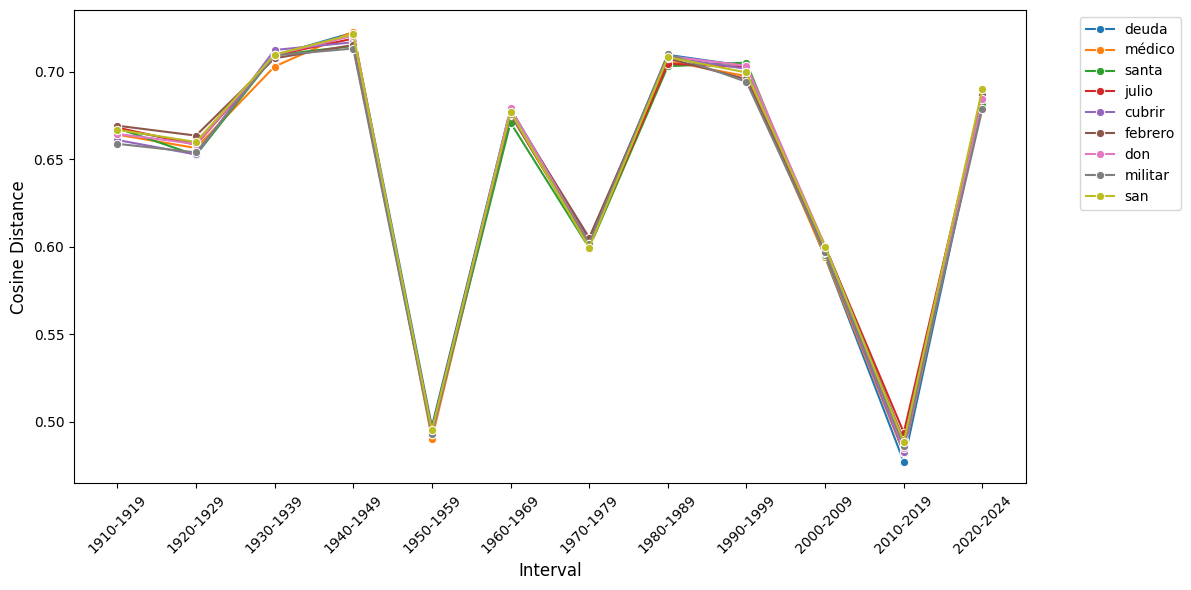

In [37]:
max_words = semantic_drift.loc[semantic_drift.groupby('target_model')['semantic_drift'].idxmax(), 'word']
selected_words = max_words.unique()
filtered_data = semantic_drift[semantic_drift['word'].isin(selected_words)]
semantic_drift_time(filtered_data, 'maximos')

We do the same but with every word that at some point had the least semantic drift

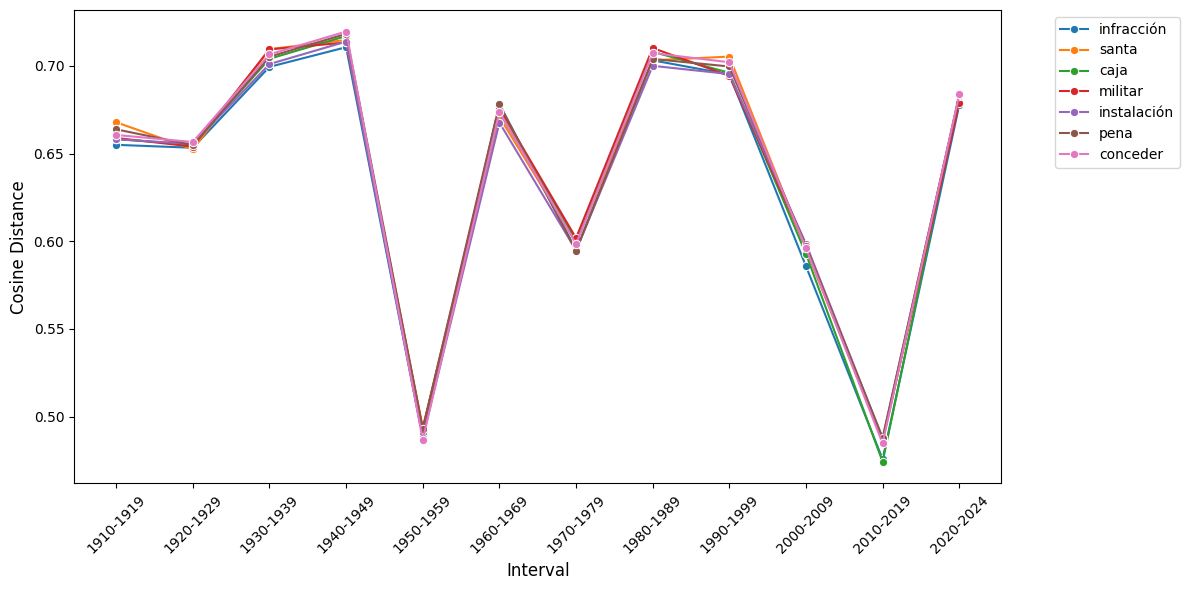

In [38]:
min_words = semantic_drift.loc[semantic_drift.groupby('target_model')['semantic_drift'].idxmin(), 'word']
selected_words = min_words.unique()
filtered_data = semantic_drift[semantic_drift['word'].isin(selected_words)]
semantic_drift_time(filtered_data, 'minimos')

In [41]:
drift = defaultdict(lambda: defaultdict(float))
for word, models in models_to_use.items():
    if word in model_1890_1909.wv:
        for model in models:
            if model != 'model_1890_1909':
                modelo = globals()[model]
                if word in modelo.wv:
                    f = projected_vector(model_1890_1909, modelo, word)
                    v = modelo.wv[word]
                    distance = 1 - cosine(v, f)
                    drift[word][model] = distance
                  
drift = pd.DataFrame(drift)

In [44]:
top_words = [word for word in important_words.head(5).index if word in drift]
drift = drift[top_words]

C:\Users\HP\AppData\Local\Temp\ipykernel_28276\376697852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drift['year_range'] = drift.index.map(extract_years)
C:\Users\HP\AppData\Local\Temp\ipykernel_28276\376697852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drift['year_start'] = drift['year_range'].map(lambda x: int(x.split('-')[0]) if '-' in x else float('inf'))


<Figure size 1200x600 with 0 Axes>

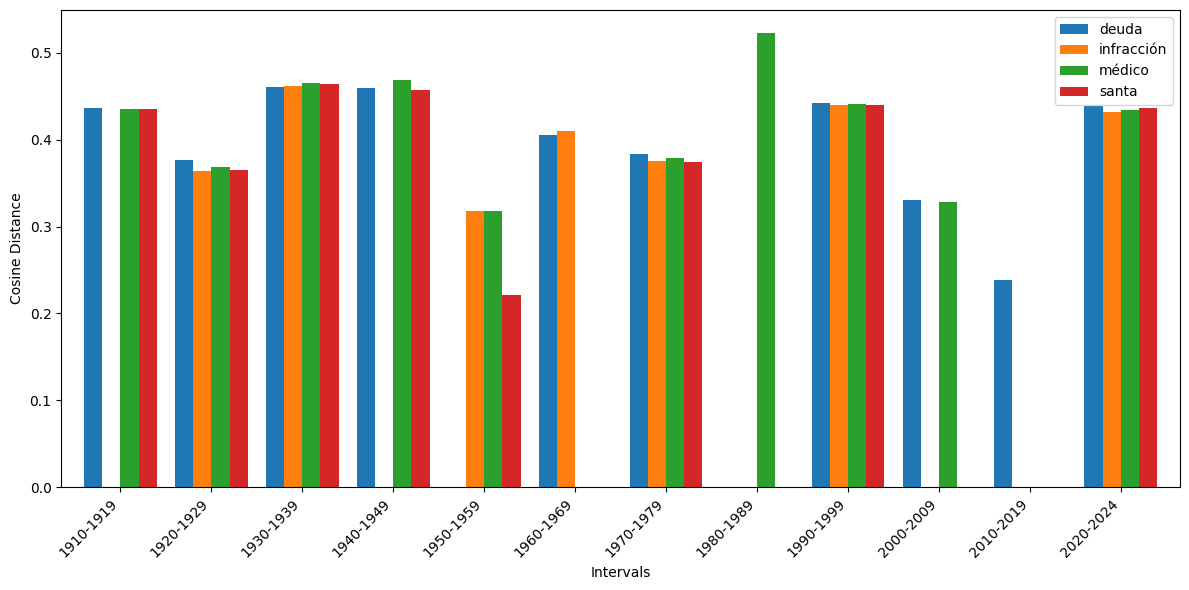

In [46]:
drift['year_range'] = drift.index.map(extract_years) 
drift['year_start'] = drift['year_range'].map(lambda x: int(x.split('-')[0]) if '-' in x else float('inf'))
drift_sorted = drift.sort_values(by='year_start').drop(columns=['year_start'])  

plt.figure(figsize=(12, 6))
ax = drift_sorted.drop(columns='year_range').plot(kind='bar', figsize=(12, 6), width=0.8)
ax.set_xlabel('Intervals')
ax.set_ylabel('Cosine Distance')
ax.set_xticklabels(drift_sorted['year_range'], rotation=45, ha='right')  
plt.tight_layout()
plt.savefig('./output/cosine_drift.png')
plt.show()

# Case Study

In [4]:
intervals = {
    'Agroexportador': list(range(1890, 1931, 1)),
    'ISI': list(range(1931, 1958, 1)),
    'Desarrollismo': list(range(1958, 1976, 1)),
    'Dictadura': list(range(1976, 1983, 1)),
    'Democracia': list(range(1983, 2000, 1)),
    'SXXI': list(range(2000, 2025, 1))
    }

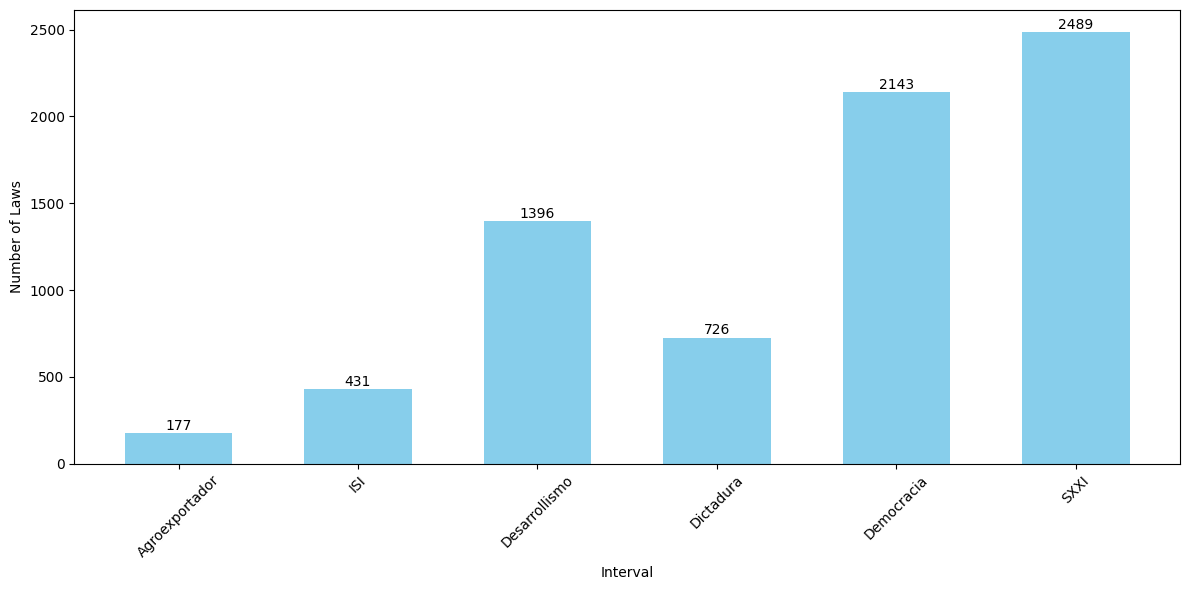

In [5]:
interval_labels = [get_interval(int(year), intervals=intervals) for _, year, _ in clean_data]
unique_intervals, counts = np.unique(interval_labels, return_counts=True)

ordered_intervals = list(intervals.keys()) 
ordered_counts = [counts[list(unique_intervals).index(interval)] if interval in unique_intervals else 0 for interval in ordered_intervals]

plt.figure(figsize=(12, 6))
plt.bar(ordered_intervals, ordered_counts, width=0.6, color='skyblue')
plt.xticks(rotation=45)

for i, count in enumerate(ordered_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.xlabel('Interval')
plt.ylabel('Number of Laws')

plt.tight_layout()
plt.savefig('./output/laws_by_interval.png')
plt.show()

In [7]:
intervals_list = []
for interval in intervals.values():
    intervals_list.append(interval)

In [ ]:
bootstrap = random_tfidf(clean_data, 111, 750, intervals= intervals_list)
bootstrap = bootstrap.fillna(0)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [12:54<00:00,  1.29it/s]


In [9]:
mean_boot = bootstrap.mean(axis = 1)
sd_boot = bootstrap.std(axis = 1)
t_stat = mean_boot*(len(bootstrap.columns)**(1/2))/sd_boot

In [15]:
important_words = t_stat.sort_values(ascending= False).index.tolist()

In [10]:
words_by_interval = words_intervals(clean_data, intervals= intervals_list)

In [11]:
for interval, words in tqdm.tqdm(words_by_interval.items()):
    globals()[f"model_{interval}"] = Word2Vec(words, vector_size= 300, window= 5, workers= 5) 

100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


In [12]:
for interval, _ in tqdm.tqdm(words_by_interval.items()):
    model = globals()[f'model_{interval}']
    with tempfile.NamedTemporaryFile(prefix= f'gensim-model-{interval}', delete=False) as tmp:
        model.save(f'./word2vec_models/gensim-model-{interval}')

100%|██████████| 6/6 [00:00<00:00, 31.16it/s]


In [13]:
for label, interval in intervals.items():
    start = interval[0]
    end = interval[-1]
    model_file = os.path.join('./word2vec_models/', f'gensim-model-{label}')
    try:
        os.path.exists(model_file)
        globals()[f'model_{label}'] = gensim.models.Word2Vec.load(model_file)
    except Exception as e:
        print(e)

In [17]:
models_to_use = defaultdict(set)
for word in important_words:
    for interval in intervals.keys():
        model = globals()[f'model_{interval}']
        if word in model.wv:
                models_to_use[word].add(f'model_{interval}')
                
models_to_use = {word: list(models) for word, models in models_to_use.items()}

In [18]:
models = []
for label in intervals.keys():
    models.append(f"model_{label}")

In [19]:
for model in models[1:]:
    model = globals()[model]
    mapping = get_mapping(model_Agroexportador, model)
    print(len(mapping))

213
202
205
209
206


In [21]:
proj = []
semantic_drift = []
for model_name in models[1:]:
    model = globals()[model_name]
    projected_words, drift_data = similar_words_df(model_Agroexportador, model, words= important_words)
    
    for entry in projected_words:
        proj.append({
            "target_model": model_name,
            "word": entry["word"],
            "similar_word": entry["similar_word"],
            "score": entry["score"]
        })
        
    for drift_entry in drift_data:
        semantic_drift.append({
            "target_model": model_name,
            "word": drift_entry["word"],
            "semantic_drift": drift_entry["semantic_drift"]
        })

proj = pd.DataFrame(proj)
semantic_drift = pd.DataFrame(semantic_drift)

In [22]:
max_words = semantic_drift.loc[semantic_drift.groupby('target_model')['semantic_drift'].idxmax(), 'word']
selected_words = max_words.unique()
filtered_data = semantic_drift[semantic_drift['word'].isin(selected_words)]

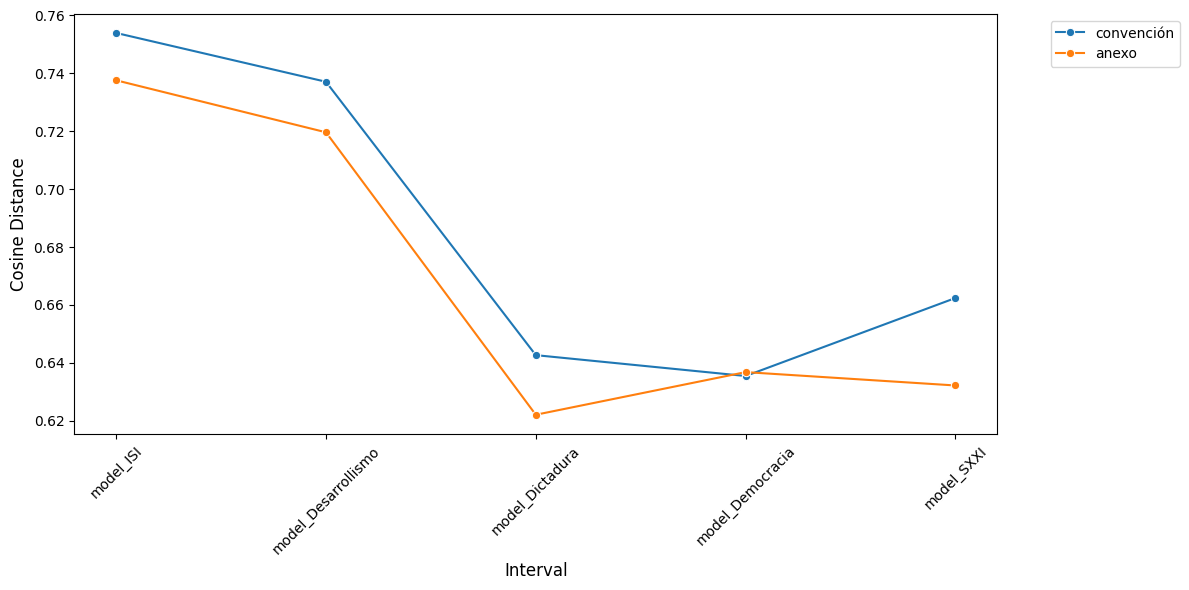

In [23]:
semantic_drift_time(filtered_data, 'maximos_case')

In [24]:
min_words = semantic_drift.loc[semantic_drift.groupby('target_model')['semantic_drift'].idxmin(), 'word']
selected_words = min_words.unique()
filtered_data = semantic_drift[semantic_drift['word'].isin(selected_words)]

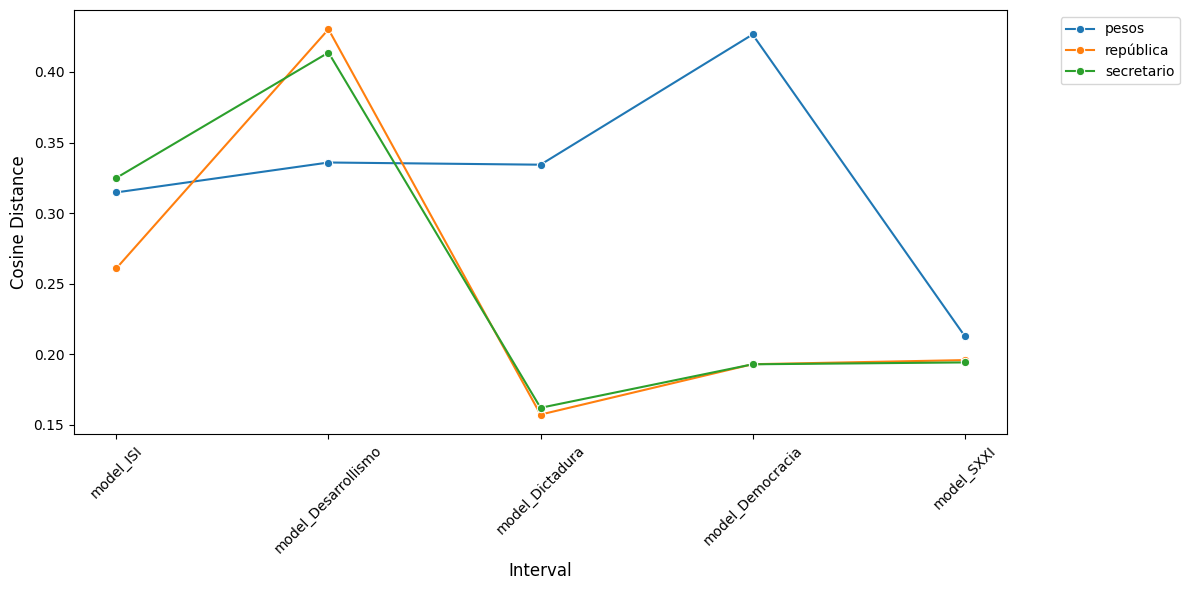

In [25]:
semantic_drift_time(filtered_data, 'minimos_case')

In [26]:
drift = defaultdict(lambda: defaultdict(float))
for word, models in models_to_use.items():
    if word in model_Agroexportador.wv:
        for model in models:
            if model != 'model_Agroexportador':
                modelo = globals()[model]
                f = projected_vector(model_Agroexportador, modelo, word)
                v = modelo.wv[word]
                distance = cosine(v, f)
                drift[word][model] = distance
                  
drift = pd.DataFrame(drift)

<Figure size 1200x600 with 0 Axes>

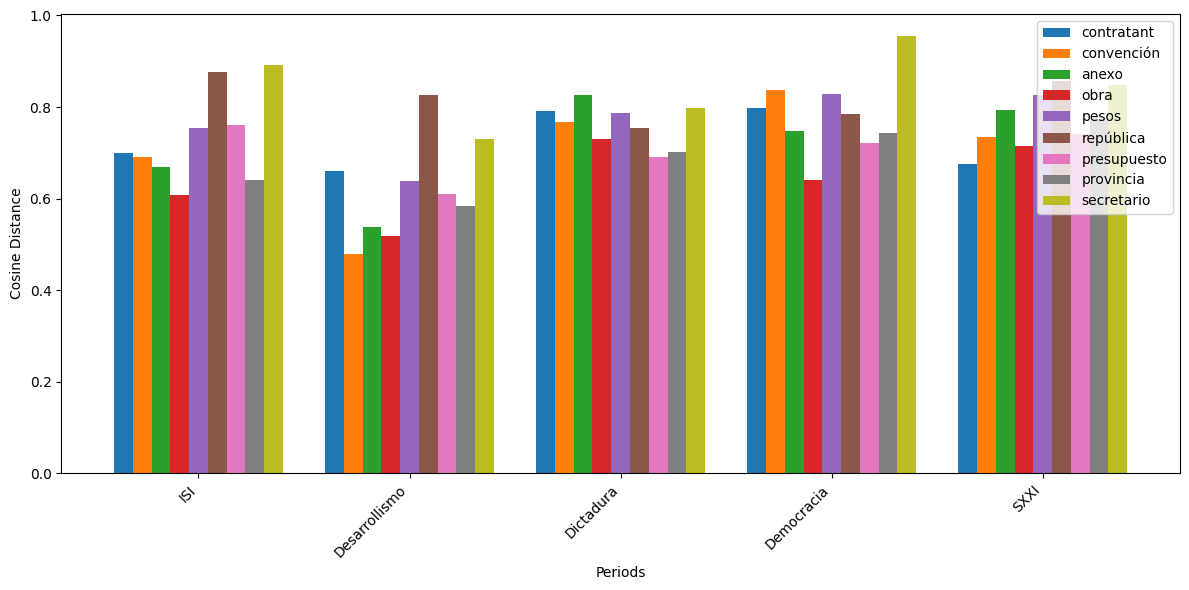

In [27]:
drift['period'] = [get_period_from_model(model, intervals) for model in drift.index]
period_order = list(intervals.keys())
drift_sorted = drift.sort_values(by='period', key=lambda x: x.map(lambda p: period_order.index(p)))
plt.figure(figsize=(12, 6))
ax = drift_sorted.drop(columns='period').plot(kind='bar', figsize=(12, 6), width=0.8)
ax.set_xlabel('Periods')
ax.set_ylabel('Cosine Distance')
ax.set_xticks(range(len(drift_sorted.index)))
ax.set_xticklabels(drift_sorted['period'], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('./output/cosine_drift_periods.png')
plt.show()